<a href="https://colab.research.google.com/github/scope-lab-vu/transactive-blockchain/blob/master/TCPS_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To make this notebook work in Colab, the following must be done:

  1. The Cplex binary installer needs to be uploaded to your Google Drive in a directory named 'ColabLibraries'
  2. Prosumer offer data should be uploaded into a directory named 'profiles'

Mount Google Drive to access installation files

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Install cplex from Google Drive. installer.properties included in directory for silent install

In [2]:
! chmod u+x /content/gdrive/My\ Drive/ColabLibraries/cplex_studio129.linux-x86-64.bin

!/content/gdrive/My\ Drive/ColabLibraries/cplex_studio129.linux-x86-64.bin -f "installer.properties"


Preparing to install
Extracting the JRE from the installer archive...
Unpacking the JRE...
Extracting the installation resources from the installer archive...
Configuring the installer for this system's environment...

Launching installer...



Install cplex python binaries

In [0]:
%%capture
! cd /opt/ibm/ILOG/CPLEX_Studio129/python/; python3 setup.py install;

Clone transax repo

In [4]:
from getpass import getpass
import os

user = getpass('GitHub User')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/scope-lab-vu/transactive-blockchain.git


GitHub User··········
GitHub password··········
Cloning into 'transactive-blockchain'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 4780 (delta 20), reused 4 (delta 1), pack-reused 4740
Receiving objects: 100% (4780/4780), 139.58 MiB | 33.34 MiB/s, done.
Resolving deltas: 100% (2188/2188), done.
Checking out files: 100% (2097/2097), done.


Install transax library

In [0]:
%%capture
! cd /content/transactive-blockchain/transax; sudo pip3 install .

Set up the microgrid and the solver

In [0]:
import cplex
from transax.Microgrid import Microgrid
from transax.MatchingSolver import Offer, MatchingSolver
microgrid = Microgrid(interval_length=1.0, C_ext=25000, C_int=250000, feeders=[0], prosumer_feeder={
    101: 0,
    102: 0,
    103: 0,
    104: 0,
    105: 0,
    201: 0,
    202: 0,
    203: 0,
    204: 0,
    207: 0,
    301: 0,
    302: 0,
    303: 0,
    304: 0,
    305: 0,
  })
solver = MatchingSolver(microgrid)

Build a dictionary of all the prosumer offers

In [0]:
import pandas as pd
import numpy as np
prosumer_df = {}
directory = os.fsencode('/content/gdrive/My Drive/profiles')
for file in os.listdir(directory):
  filename = os.fsdecode(file)
  prosumer_id = int(filename.split('_')[1].split('.')[0])
  prosumer_df[prosumer_id] = pd.read_csv('/content/gdrive/My Drive/profiles/' + filename)


Create lists for buying and selling offers, also determine total energy on the grid. Consumption is represented with positive values, production is represented with negative values.

In [0]:
buying_offers = []
selling_offers = []
total_energy = 0
for key, prosumer in prosumer_df.items():
  for row in prosumer.iterrows():
      startTime = int(row[1]['startTime'])
      endTime = int(row[1]['endTime'])
      energy = float(row[1]['energy'])
      total_energy = total_energy + energy
      offer = Offer(key, key, startTime, endTime, np.abs(energy), 1)
      if energy < 0:
        buying_offers.append(offer)
      elif energy > 0:
        selling_offers.append(offer)

Determine total energy traded after all offers have been matched

In [116]:
(trades, objective) = solver.solve(buying_offers=buying_offers, selling_offers=selling_offers)
print("Success: {} energy traded".format(objective))

Success: 765.8317905248687 energy traded


Case 1: All prosumers produce/consume exactly what they offered. Find total demand on DSO.



In [112]:
unmet_energy = np.abs(total_energy)-objective
print('Prosumers produce as anticipated. Load on DSO: {}'.format(unmet_energy))

Prosumers produce as anticipated. Load on DSO: 157.58606322981495


Case 2: Prosumers' offers are all incorrect by a normal distribution.

In [11]:
total_energy = 0
for prosumer in prosumer_df.values():
  for row in prosumer.iterrows():
      energy = float(row[1]['energy']) + np.random.normal(0,1)
      total_energy = total_energy + energy

unmet_energy = np.abs(total_energy)-objective
print('Each offer is incorrect by a normal distribution. Load on DSO: {}'.format(unmet_energy))

Each offer is incorrect by a normal distribution. Load on DSO: 116.91444967008363


Case 3: Producers consistently overestimate their production ability. (i.e. a cloudy day that was supposed to be clear)

In [12]:
total_energy = 0
for prosumer in prosumer_df.values():
  for row in prosumer.iterrows():
      energy = float(row[1]['energy'])
      if energy > 0:
        energy = energy - np.random.exponential(1)
      total_energy = total_energy + energy

unmet_energy = np.abs(total_energy)-objective
print('Producers consistently overestimate production. Load on DSO: {}'.format(unmet_energy))

Producers consistently overestimate production. Load on DSO: 726.5899900837449


Plot of loss of trading volume vs. offer error


In [0]:
perc_errors_norm = np.array([0.05, 0.1 ,0.25, 0.5, 0.75])
num_exp = 1000
total_energy_norm = np.zeros((num_exp, len(perc_errors_norm)))
for dfRow in total_energy_norm.iterrows():
  # for idx, error in enumerate(perc_errors_norm):
    for prosumer in prosumer_df.values():
      for row in prosumer.iterrows():
        energy = float(row[1]['energy'])
        energy = energy if energy == 0 else energy + np.random.normal(0,np.abs(perc_errors_norm*energy),(1,len(perc_errors_norm)))
        dfRow[1].iloc[idx] = dfRow[1].iloc[idx] + energy

In [0]:
avg_unmet_energy_norm = np.abs(total_energy_norm.mean(axis=0)-objective)
trading_loss_norm = np.abs(avg_unmet_energy_norm-avg_unmet_energy_norm.iloc[0])

Text(0.5, 1.0, 'Trading Loss As a Function of Normally Distributed Error')

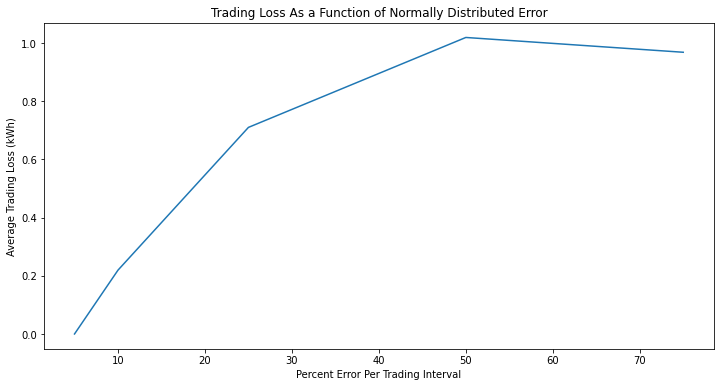

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
plt.plot(np.multiply(perc_errors_norm,100), trading_loss_norm)
plt.xlabel('Percent Error Per Trading Interval')
plt.ylabel('Average Trading Loss (kWh)')
plt.title('Trading Loss As a Function of Normally Distributed Error')

In [0]:
perc_errors = [0 ,0.05, 0.1,0.25]
num_exp = 10
total_energy_exp = pd.DataFrame(np.zeros((num_exp, len(perc_errors))))
for dfRow in total_energy_exp.iterrows():
  for idx, error in enumerate(perc_errors):
    for prosumer in prosumer_df.values():
      for row in prosumer.iterrows():
        # If prosumer is a producer, reduce the amount that they actually produce
        # Beta is created as a percentage of the energy anticipated to be sold in that period
          energy = float(row[1]['energy'])
          energy = energy if energy < 0 else energy + np.random.exponential(error*energy)
          dfRow[1].iloc[idx] = dfRow[1].iloc[idx] + energy

In [0]:
avg_unmet_energy_exp = np.abs(total_energy_exp.mean(axis=0)-objective)
trading_loss_exp = np.abs(avg_unmet_energy_exp-avg_unmet_energy_exp.iloc[0])

Text(0.5, 1.0, 'Trading Loss as a Function of Exponentially Distributed Error')

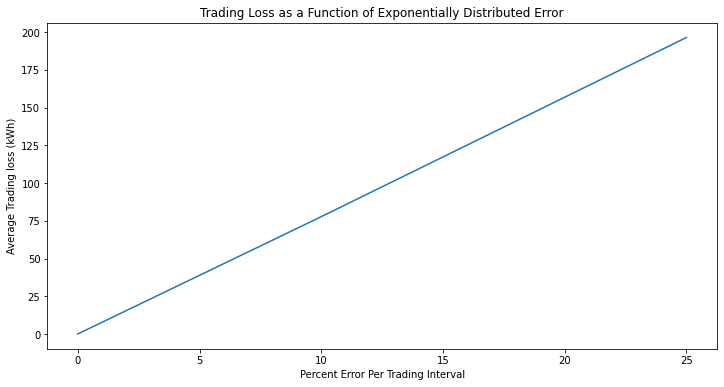

In [237]:
fig = plt.figure(figsize=(12,6))
plt.plot(np.multiply(perc_errors,100), trading_loss_exp)
plt.xlabel('Percent Error Per Trading Interval')
plt.ylabel('Average Trading loss (kWh)')
plt.title('Trading Loss as a Function of Exponentially Distributed Error')

In [36]:

np.random.normal(0,1,prosumer_df[101]['energy'].shape)

array([ 0.24841442, -0.92925231,  0.01843932,  0.83050639,  0.76506065,
       -0.53351674,  0.31352093, -1.02337585, -0.28219881, -1.08740164,
        0.24372044, -0.54887042,  1.21806235, -2.00013374,  1.03908187,
       -0.94197003, -0.60266063,  0.824805  , -0.03165901, -0.78330414,
        2.0877519 , -0.03000277, -0.73525983, -0.41795426,  0.56081715,
       -0.45789384, -0.7436094 ,  0.77179225,  1.48603576, -0.91942944,
        0.89656386, -1.67195152,  0.33802147,  0.87833161, -0.08939981,
       -0.0916133 , -0.98815816, -0.24850045,  0.60566175,  1.25524043,
       -0.25443146, -0.58907477,  0.18656679, -0.17475124,  0.08908174,
        0.68165528, -0.23935456,  0.43468197, -1.36895364,  0.95254176,
        0.80488437,  1.76053078,  0.57240148, -0.39770515,  0.23638449,
       -0.26818147, -0.6473926 , -0.36674658, -2.13122589,  0.7614319 ,
       -0.11231801, -1.20162695, -0.72900173, -1.21831307,  0.31537099,
       -1.57111286,  1.37347646, -1.11928104, -1.1698022 , -0.00

In [0]:
num_exp = 1000
perc_errors_norm = np.array([0,0.05, 0.1 ,0.25, 0.5, 0.75])
prosumer_production = np.zeros((len(perc_errors_norm)))
total_production = np.zeros((num_exp,len(perc_errors_norm)))
for prosumer in prosumer_df.values():
    energy_col = prosumer['energy']
    length = len(energy_col)
    st_dev = np.multiply(perc_errors_norm,np.abs(energy_col).max())
    for idx in range(num_exp):
      energy_with_errors =  energy_col.values.reshape(length,1) + np.random.normal(0,st_dev,(length,len(perc_errors_norm)))
      prosumer_production = np.sum(energy_with_errors, axis = 0)
      total_production[idx,:] = total_production[idx,:] + prosumer_production

In [0]:
total_production_avg = np.mean(total_production,axis=0)
trading_loss = np.abs(total_production_avg-total_production[0])

Text(0.5, 1.0, 'Trading Loss as a Function of Normally Distributed Error')

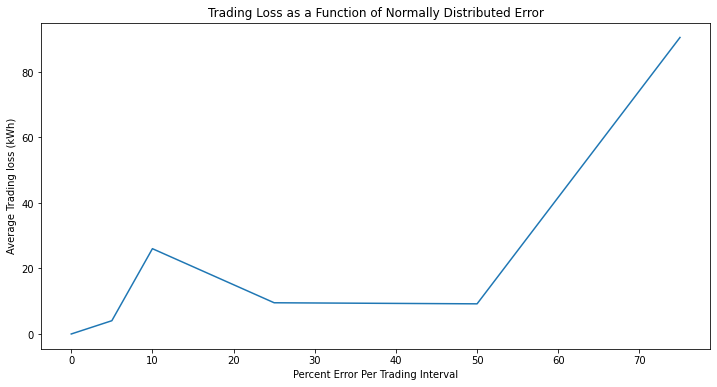

In [248]:
fig = plt.figure(figsize=(12,6))
plt.plot(np.multiply(perc_errors_norm,100), trading_loss.flatten())
plt.xlabel('Percent Error Per Trading Interval')
plt.ylabel('Average Trading loss (kWh)')
plt.title('Trading Loss as a Function of Normally Distributed Error')

In [0]:
total = 0
for prosumer in prosumer_df.values():
  total = total+np.sum(prosumer['energy'])
# for num, trade in enumerate(trades):
#   total = total + trade['p']


In [231]:
total_production[0]

array([   0.        ,  -16.96203691,   32.29748716,  -21.7147015 ,
         61.82417156, -126.38558619])

In [84]:
objective

765.8317905248687

In [85]:
trades

dict_values([{'s': <transax.MatchingSolver.Offer object at 0x7f398a9d8048>, 'b': <transax.MatchingSolver.Offer object at 0x7f398a9d9ef0>, 't': 26, 'p': 0.0}, {'s': <transax.MatchingSolver.Offer object at 0x7f398a9d8da0>, 'b': <transax.MatchingSolver.Offer object at 0x7f398a9d9ef0>, 't': 26, 'p': 0.0}, {'s': <transax.MatchingSolver.Offer object at 0x7f398a9ddef0>, 'b': <transax.MatchingSolver.Offer object at 0x7f398a9d9ef0>, 't': 26, 'p': 0.0}, {'s': <transax.MatchingSolver.Offer object at 0x7f398a9e3be0>, 'b': <transax.MatchingSolver.Offer object at 0x7f398a9d9ef0>, 't': 26, 'p': 0.00037078273748724066}, {'s': <transax.MatchingSolver.Offer object at 0x7f398a9eed68>, 'b': <transax.MatchingSolver.Offer object at 0x7f398a9d9ef0>, 't': 26, 'p': 0.0}, {'s': <transax.MatchingSolver.Offer object at 0x7f398a9f3ac8>, 'b': <transax.MatchingSolver.Offer object at 0x7f398a9d9ef0>, 't': 26, 'p': 0.0}, {'s': <transax.MatchingSolver.Offer object at 0x7f398a993908>, 'b': <transax.MatchingSolver.Offer 

In [117]:
total_energy

-923.4178537546836

In [148]:
prosumer_production.shape

(91, 6)

In [175]:
np.multiply(perc_errors_norm,4).reshape(length)

ValueError: ignored

In [227]:
total_production_avg

array([ 0.        , -0.06372341,  0.43115444, -0.19285426,  0.41542103,
       -1.67908534])

In [229]:
total_production.shape

(10000, 6)

In [249]:
total_production[1,:]

array([ -923.41785375,  -919.16052936,  -929.77969967,  -971.41664487,
       -1043.20855265,  -883.02490022])